In [1]:
prfx = "trn0018" 

In [2]:
%load_ext autoreload
%autoreload 2
%aimport

!nvidia-smi

Modules to reload:
all-except-skipped

Modules to skip:

Sat Apr 17 18:46:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   33C    P0    22W / 300W |     11MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                   

- https://github.com/haqishen/Google-Landmark-Recognition-2020-3rd-Place-Solution
- https://www.kaggle.com/zzy990106/b0-bert-cv0-9
- https://github.com/yang-zhang/product_category/blob/dev/notebooks/transformer_20210307E1--pin_memory.ipynb

# train

In [3]:
HOME = "/data/git/shopee-product-matching"
p_out = f'{HOME}/output/{prfx}'
!mkdir -p {p_out}
p_prp = f'{HOME}/output/prep002'

FOLD = 0
FP16 = False

import sys
sys.path.append(f"{HOME}/src")

import pandas as pd
from argparse import ArgumentParser
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pl_model import ShpModel, ShpDataModule
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [4]:
parser = ArgumentParser()
parser.add_argument(
    "--imgsz",
    help="Image size.",
    type=int,
    default=224,
)
parser.add_argument(
    "--train_batch_size",
    help="How many samples per batch to load for train dataloader.",
    type=int,
    default=64,
)
parser.add_argument(
    "--val_batch_size",
    help="How many samples per batch to load for validation dataloader.",
    type=int,
    default=128,
)
parser.add_argument(
    "--dataloader_num_workers",
    help="How many subprocesses to use for data loading. 0 means that the data will be loaded in the main process.",
    type=int,
    default=8,
)
parser.add_argument(
    "--pin_memory",
    help="Wether to use pin_memory in pytorch dataloader. If True, the data loader will copy Tensors into CUDA pinned memory before returning them.",
    action="store_true",
)

parser = pl.Trainer.add_argparse_args(parser)
parser = ShpModel.add_model_specific_args(parser)
args_list = [
    '--default_root_dir', p_out,
    '--kernel-type', '',
    '--enet-type', 'tf_efficientnet_b1_ns',
    '--imgsz', '512',
    "--train_batch_size", '64',
    "--val_batch_size", '128',]

args = parser.parse_args(args_list)

In [5]:
df = pd.read_csv(f"{p_prp}/df_train.csv")
display(df.head(3))
dftrn = df[df.fold!=FOLD].copy()
dfval = df[df.fold==FOLD].copy()
print(dftrn.shape, dfval.shape)

data_module = ShpDataModule(
    dftrn=dftrn,
    dfval=dfval,
    train_batch_size=args.train_batch_size,
    val_batch_size=args.val_batch_size,
    pin_memory=args.pin_memory,    
    
)

,index,posting_id,image,image_phash,title,label_group,filepath,fold
0,0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,/data/git/shopee-product-matching/input/shopee...,0
1,1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,/data/git/shopee-product-matching/input/shopee...,2
2,2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,/data/git/shopee-product-matching/input/shopee...,0


(23292, 8) (5823, 8)


In [6]:
data_module.setup()
data_module.num_classes

9369

In [7]:
shpmodel = ShpModel(
    kernel_type=args.kernel_type,
    enet_type=args.enet_type,
    learning_rate=args.learning_rate,
    num_classes=data_module.num_classes,
    margins=data_module.margins,
)

In [8]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger

csv_logger = CSVLogger(p_out, name='csv')
tb_logger = TensorBoardLogger(p_out, name='tensorboard')

trainer = pl.Trainer.from_argparse_args(args, 
#                                         fast_dev_run=True,
                                        max_epochs=30,
                                        callbacks=[EarlyStopping(monitor='valid_accu', patience=2)],
                                        stochastic_weight_avg=True,
                                        log_gpu_memory=True, 
                                        gpus=1,
                                        logger=[tb_logger,csv_logger],
                                        precision=16 if FP16 else 32,
                                       )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [9]:
pl.seed_everything(1234)
trainer.fit(shpmodel, data_module)

Global seed set to 1234
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                      | Params
-------------------------------------------------------
0 | model    | Effnet_Landmark           | 21.6 M
1 | arc      | ArcFaceLossAdaptiveMargin | 0     
2 | accuracy | Accuracy                  | 0     
-------------------------------------------------------
21.6 M    Trainable params
0         Non-trainable params
21.6 M    Total params
86.239    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/data/anaconda3/envs/shopee/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:148: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

In [10]:
ls -hl {p_out}/tensorboard_csv/*/checkpoints/*.ckpt

-rw-rw-r-- 1 ubuntu ubuntu 248M Apr 17 19:53 '/data/git/shopee-product-matching/output/trn0018/tensorboard_csv/0_0/checkpoints/epoch=20-step=7643.ckpt'


In [11]:
!nvidia-smi

Sat Apr 17 19:53:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   40C    P0    48W / 300W |   1578MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# load model

In [12]:
HOME = "/data/git/shopee-product-matching"
p_out = f'{HOME}/output/{prfx}'
p_prp = f'{HOME}/output/prep002'

import sys
sys.path.append(f"{HOME}/src")

import torch
from final import enet_arcface_FINAL, load_model
from pl_model import ShpModel
from dataset import ShopeeDataset, get_transforms
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm

In [13]:
device = torch.device('cuda')
shpmodel = ShpModel.load_from_checkpoint(f'{HOME}/output/{prfx}/tensorboard_csv/0_0/checkpoints/epoch=20-step=7643.ckpt')
out_dim = shpmodel.num_classes


model = enet_arcface_FINAL(args.enet_type, out_dim=out_dim).to(device)
model = load_model(model, shpmodel)
model = model.to(device)

    


# utils

In [14]:
import numpy as np

def getf1(x, y):
    n = len(np.intersect1d(x, y))
    return 2 * n / (len(x) + len(y))


def getf1s(xs, ys):
    return (getf1(x, y) for x, y in zip(xs, ys))


def meanf1(xs, ys):
    return np.mean(list(getf1s(xs, ys)))


def get_targets(df):
    grp2ids = df.groupby("label_group").posting_id.agg("unique").to_dict()
    targets = df.label_group.map(grp2ids)
    return targets

def preds2pids(preds, pids):
    return [pids[o] for o in preds]


def comb_preds(*preds):
    return (np.unique(np.concatenate(l)) for l in zip(*preds))


In [15]:
df = pd.read_csv(f"{p_prp}/df_valid.csv")
pids = df.posting_id.values
targets = get_targets(df)

display(df.head(3))

,index,posting_id,image,image_phash,title,label_group,filepath
0,6,train_1802986387,00144a49c56599d45354a1c28104c039.jpg,f815c9bb833ab4c8,Jubah anak size 1-12 thn,1835033137,/data/git/shopee-product-matching/input/shopee...
1,7,train_1806152124,0014f61389cbaa687a58e38a97b6383d.jpg,eea7e1c0c04da33d,KULOT PLISKET SALUR /CANDY PLISKET /WISH KULOT...,1565741687,/data/git/shopee-product-matching/input/shopee...
2,16,train_3009013664,0027aaf8dd8bdbf0e4f2c19024e436cf.jpg,b3cccc26cc3333cc,MARKS & SPENCER - Rose Hand & Body Lotion 250 ml,1574620312,/data/git/shopee-product-matching/input/shopee...


# get feats

In [16]:
tfms_trn, tfms_val = get_transforms(args.imgsz)
ds = ShopeeDataset(df, mode="test", transform=tfms_val)
dl = DataLoader(ds,
            batch_size=32,
            num_workers=8,
            pin_memory=True,
        )

feats = np.zeros((len(ds), 512))
i = 0
for dat in tqdm(dl):
    with torch.no_grad():
        dat = dat.to(device)
        feat,_ = model(dat)
        l = len(feat)
        feats[i : i + l, :] = feat.cpu().detach().numpy()
        i += l

100%|██████████| 161/161 [00:33<00:00,  4.87it/s]


# inference

In [17]:
from cuml.neighbors import NearestNeighbors
import numpy as np
import torch.nn.functional as F


N_NBRS = 50
CHUNK = 1024 * 4


def mk_nnmdl(feats, n_nbrs=N_NBRS):
    nnmdl = NearestNeighbors(N_NBRS, metric="cosine")
    nnmdl.fit(feats)
    return nnmdl


def get_nbrs_from_nnmdl(feats, nnmdl, sz_chunk=CHUNK):
    n = len(feats)
    n_nbrs = nnmdl.n_neighbors
    dists = np.zeros((n, n_nbrs), dtype="float")
    idx = np.zeros((n, n_nbrs), dtype="int")
    n_chunks = len(feats) // sz_chunk
    if len(feats) % sz_chunk != 0:
        n_chunks += 1
    for j in tqdm(range(n_chunks)):
        a = j * sz_chunk
        b = (j + 1) * sz_chunk
        b = min(b, len(feats))
        dists_, idx_ = nnmdl.kneighbors(
            feats[
                a:b,
            ]
        )
        dists[a:b] = np.array(dists_)
        idx[a:b] = np.array(idx_)
    return dists, idx


def get_nbrs(feats, n_nbrs=N_NBRS, sz_chunk=CHUNK):
    nnmdl = mk_nnmdl(feats, n_nbrs)
    dists, idx = get_nbrs_from_nnmdl(feats, nnmdl, sz_chunk)
    return dists, idx


def get_preds_by_thrsh(dists, idx, thrsh):
    preds = (ind[dst < thrsh] for dst, ind in zip(dists, idx))
    return preds


def find_best(dists, idx, thrshes=np.linspace(0.,1.,num=21)):
    f1_lst = []
    preds_lst = []
    for thrsh in tqdm(thrshes):
        preds = get_preds_by_thrsh(dists, idx, thrsh)
        preds = preds2pids(preds, pids)
        preds_lst.append(preds)
        f1 = meanf1(preds,targets)
        f1_lst.append(f1)
    f1_best, thrsh_best, preds_best = sorted(zip(f1_lst, thrshes, preds_lst), reverse=True)[0]
    res = {'f1_best': f1_best, 
           'thrsh_best': thrsh_best, 
           'preds_best': preds_best, 
           'thrshes': thrshes, 
           'f1_lst': f1_lst}
    return res

In [18]:
nbrs = get_nbrs(feats)

100%|██████████| 2/2 [00:00<00:00,  3.38it/s]


In [19]:
dists, idx = nbrs
res = find_best(dists, idx)
print(f"{res['f1_best']:.3f}, {res['thrsh_best']:.2f} ")

100%|██████████| 21/21 [00:04<00:00,  4.97it/s]

0.764, 0.50 


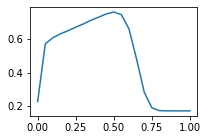

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3,2))
plt.plot(res['thrshes'], res['f1_lst'])  
plt.show()

In [21]:
preds_v = res['preds_best']

In [22]:
meanf1(preds_v, targets)

0.763525304258169